# Waveform Classification using Convolutional Neural Network

>Gong Zerui, last updated: 20.06.15

* CNN under tensorflow framework

### Import librarires

In [9]:
# import necessary libraries
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

# for waveform analysis
TEST_DATASET_PATH = "E:\\Data\\TestSet\\"
TEST_CATEGORIES = ['OverSaturated', 'UnderSaturated', 'JustSaturated']

MODEL_PATH = 'E:\\Model\\'
CNN_PREPROCESSING_BUFFER_PATH = 'E:\\Data\\PreprocessingBuffer\\'
FAILED_TESTCASES_PATH = "E:\\Data\\Failed Testset\\"
CROPPED_DATASET_PATH = 'E:\\Data\\LargeSet\\Cropped\\'

OVERSATURATED_DATASET_PATH = 'E:\\Data\\LargeSet\\OverSaturated'
UNDERSATURATED_DATASET_PATH = 'E:\\Data\\LargeSet\\UnderSaturated'
JUSTSATURATED_DATASET_PATH = 'E:\\Data\\LargeSet\\JustSaturated'

OVERSATURATED_CROPPED_DATASET_PATH = 'E:\\Data\\LargeSet\\Cropped\\OverSaturated'
UNDERSATURATED_CROPPED_DATASET_PATH = 'E:\\Data\\LargeSet\\Cropped\\UnderSaturated'
JUSTSATURATED_CROPPED_DATASET_PATH = 'E:\\Data\\LargeSet\\Cropped\\JustSaturated'


In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Check directory folders

In [11]:
# define directories and categories
data_dir = CROPPED_DATASET_PATH
categories = ['JustSaturated','UnderSaturated','OverSaturated']

# check if the directory exists
if os.path.exists(data_dir):
    print('Directory exists')
else:
    print('Directory does not exist')



Directory exists


### Split data into training and validation sets
* ratio is 70% : 30%
* reate train and val folder in specified folders

In [12]:
# split the data into training and validation sets
import random


train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# define the ratio for splitting the data
split_ratio = 0.70
total_train = 0
total_val = 0

# loop through each category and split the data
for cat in categories:
    img_files = os.listdir(os.path.join(data_dir, cat))
    num_train = int(len(img_files)*split_ratio)
    random.shuffle(img_files)  # shuffle the list of image files
    train_files = img_files[:num_train]
    val_files = img_files[num_train:]

    total_train += len(train_files)
    total_val += len(val_files)

    os.makedirs(os.path.join(train_dir, cat), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cat), exist_ok=True)
    for fname in train_files:
        shutil.copy(os.path.join(data_dir, cat, fname), os.path.join(train_dir, cat, fname))
    for fname in val_files:
        shutil.copy(os.path.join(data_dir, cat, fname), os.path.join(val_dir, cat, fname))


### Image preprocessing
* set height and width of the images that the model will receive : 670 * 240
* set batch size (number of images to be used in one update cycle) : 32
* augmentation: rescaling, rotation, shift, zoom, flip

In [13]:
# Preprocess the images
IMG_HEIGHT, IMG_WIDTH = 240, 670
BATCH_SIZE = 32

# Introduce data augmentation to the training set
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# We do not apply any augmentation on validation data
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 6089 images belonging to 3 classes.
Found 2612 images belonging to 3 classes.


### Model definition and training
* Classic CNN model
* Convolutional Layers and Pooling
    ```
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    ```
    These are the first set of convolutional, pooling, and dropout layers. Convolutional layers are used to detect features or patterns in the images, like edges, corners, etc. The pooling layer reduces the dimensionality of the images, helping to prevent overfitting. The dropout layer randomly drops out a percentage of the neurons during training to also prevent overfitting.
* Fully Connected Layers
    ```
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),  
    Dense(3)
    ```
    After several convolutional and pooling layers, we flatten the data to a one-dimensional array and feed it into a fully connected (Dense) layer. This layer will learn global patterns from the features detected by previous layers. We apply dropout again for regularisation, and the final layer outputs the class probabilities.
* Compile Model
    ```
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])
    ```
    The model is compiled with the Adam optimizer, and the learning rate is set. The loss function is categorical cross-entropy, which is suitable for multiclass classification tasks. We're also setting accuracy as our evaluation metric.
* Model Training:
    ```
    history = model.fit(
    train_generator,
    steps_per_epoch=total_train // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=total_val // BATCH_SIZE,
    callbacks=[early_stop]
    )
    ```
    The model is then trained using the fit method, using generators to provide batches of images. The training process is also validated on a separate set of data. The 'early stop' callback is used to stop training when the model isn't improving on the validation data, preventing wasted computation.


Epoch 1/20
95/95 [==============================] - 312s 3s/step - loss: 1.1118 - accuracy: 0.5240 - val_loss: 0.9042 - val_accuracy: 0.6664
Epoch 2/20
95/95 [==============================] - 299s 3s/step - loss: 0.9603 - accuracy: 0.6042 - val_loss: 0.7435 - val_accuracy: 0.6469
Epoch 3/20
95/95 [==============================] - 292s 3s/step - loss: 0.8470 - accuracy: 0.6715 - val_loss: 0.5446 - val_accuracy: 0.8734
Epoch 4/20
95/95 [==============================] - 294s 3s/step - loss: 0.7637 - accuracy: 0.7143 - val_loss: 0.4705 - val_accuracy: 0.8586
Epoch 5/20
95/95 [==============================] - 294s 3s/step - loss: 0.7103 - accuracy: 0.7391 - val_loss: 0.3179 - val_accuracy: 0.9664
Epoch 6/20
95/95 [==============================] - 289s 3s/step - loss: 0.6581 - accuracy: 0.7604 - val_loss: 0.4013 - val_accuracy: 0.9117
Epoch 7/20
95/95 [==============================] - 307s 3s/step - loss: 0.6027 - accuracy: 0.7958 - val_loss: 0.3675 - val_accuracy: 0.9570


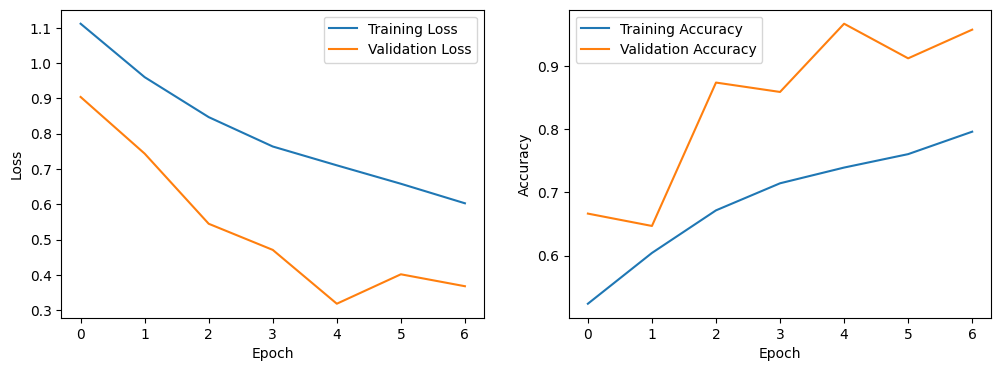

In [14]:

# Define the model
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),  
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),  
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),  
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # added L2 regularization
    Dropout(0.5),  
    Dense(3)  # number of classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Update batch size and epochs
BATCH_SIZE = 64 
EPOCHS = 20

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value
)
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=total_train // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=total_val // BATCH_SIZE,
    callbacks=[early_stopping]
)
# Plotting the training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Save the trained model

In [15]:
# save the model and rename according to the number of epochs and timestamp
import datetime
now = datetime.datetime.now()
model_name = 'model_' + str(EPOCHS) + '_' + now.strftime("%Y%m%d-%H%M%S") + '.h5'
model.save(MODEL_PATH + model_name)


In [16]:
# Generate a txt file with detailed information about the model
with open(MODEL_PATH + model_name + '.txt', 'w') as f:
    f.write('Model name: ' + model_name + '\n')
    f.write('Number of epochs: ' + str(EPOCHS) + '\n')
    f.write('Batch size: ' + str(BATCH_SIZE) + '\n')
    f.write('Image height: ' + str(IMG_HEIGHT) + '\n')
    f.write('Image width: ' + str(IMG_WIDTH) + '\n')
    f.write('Total training images: ' + str(total_train) + '\n')
    f.write('Total validation images: ' + str(total_val) + '\n')
    f.write('Training accuracy: ' + str(history.history['accuracy'][-1]) + '\n')
    f.write('Validation accuracy: ' + str(history.history['val_accuracy'][-1]) + '\n')
    f.write('Training loss: ' + str(history.history['loss'][-1]) + '\n')
    f.write('Validation loss: ' + str(history.history['val_loss'][-1]) + '\n')
    f.write('Timestamp: ' + now.strftime("%Y%m%d-%H%M%S") + '\n')
    f.write('Model summary: ' + '\n')
    model.summary(print_fn=lambda x: f.write(x + '\n'))  # save model summary to txt file

    